In [1]:
%matplotlib inline
import util
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
train_data = []
test_data = []
test_names = []
train_names = []
total_amount = 0
for root, files in util.get_person_images('../lfw_funneled/', 'jpg', 70):
    name, data, amount = util.get_dataset(root, files, 2, 3.2) # TODO: nur zentralen Pixel nehmen
    test_amount = int(np.ceil(amount*0.4))
    train_amount = int(np.floor(amount*0.6))
    index = np.arange(0, amount, dtype=np.int)
    total_amount = total_amount + amount
    # shuffle index to select random images
    np.random.shuffle(index)
    # save name vector
    test_names.extend([name]*test_amount)
    train_names.extend([name]*train_amount)
    train_data.append(np.asmatrix([data[index] for index in index[test_amount:]]))
    test_data.append(np.asmatrix([data[index] for index in index[:test_amount]]))
    print("{} hat {} Trainings Bilder und {} Test Bilder".format(name, train_amount, test_amount))

Colin_Powell hat 141 Trainings Bilder und 95 Test Bilder
George_W_Bush hat 318 Trainings Bilder und 212 Test Bilder
Hugo_Chavez hat 42 Trainings Bilder und 29 Test Bilder
Ariel_Sharon hat 46 Trainings Bilder und 31 Test Bilder
Tony_Blair hat 86 Trainings Bilder und 58 Test Bilder
Gerhard_Schroeder hat 65 Trainings Bilder und 44 Test Bilder
Donald_Rumsfeld hat 72 Trainings Bilder und 49 Test Bilder


In [3]:
train_design_matrix = np.asmatrix(np.concatenate(train_data))
test_design_matrix = np.asmatrix(np.concatenate(test_data))

In [4]:
print("Insgesamt gibt es {} Trainings Bilder und {} Test Bilder".format(train_design_matrix.shape[0], test_design_matrix.shape[0]))

Insgesamt gibt es 770 Trainings Bilder und 518 Test Bilder


In [5]:
# align test and training data
train_mean = np.mean(train_design_matrix, axis=1)
test_mean = np.mean(test_design_matrix, axis=1)
train_aligned = train_design_matrix - train_mean
test_aligned = test_design_matrix - test_mean

In [6]:
u, d, v = np.linalg.svd(train_aligned, full_matrices=False)
u.shape, d.shape, v.shape

((770, 770), (770,), (770, 2209))

In [7]:
features = 7
train_projected = np.dot(v[:features], train_aligned.T).T
test_projected = np.dot(v[:features], test_aligned.T).T

In [8]:
print("Shape Projiziert: train {}, test {}".format(np.shape(train_projected), np.shape(test_projected)))

Shape Projiziert: train (770, 7), test (518, 7)


In [9]:
person = 'George_W_Bush'
#person = 'Ariel_Sharon'

train_mask_george = np.asmatrix(train_names) == person
test_mask_george = np.asmatrix(test_names) == person
train_george = np.compress(train_mask_george[0,:], train_projected, axis=0)
train_not_george = np.compress((~train_mask_george)[0,:], train_projected, axis=0)
train_labels = np.asarray([-1 if b else 1 for b in train_mask_george[0,:]])

test_george = np.compress(test_mask_george[0,:], test_projected, axis=0)
test_not_george = np.compress(~test_mask_george[0,:], test_projected, axis=0)
test_labels = np.asarray([-1 if b else 1 for b in test_mask_george[0,:]])

In [10]:
print("Im Trainingsdatensatz sind {} Bilder von George Bush und {} Bilder nicht von George Bush".format(train_george.shape[0], train_not_george.shape[0]))

Im Trainingsdatensatz sind 318 Bilder von George Bush und 452 Bilder nicht von George Bush


In [11]:
george_perceptron = util.Perceptron((train_george, train_not_george))
george_gaussian = util.GaussianNaiveBayes((train_george, train_not_george))

data set length: 770
data point dimension: 7
R: 125.18690441130492


Did not find linear seperation after 77770 steps
correction steps: 486
Last step: b = [ 0.], 
	   w = [-0.04027086  0.4266511  -0.42459731  2.79902855 -0.30884299 -1.43769885
 -0.45717172]
Functional margin min and max: -10.313563215565425, 30.58636197100177


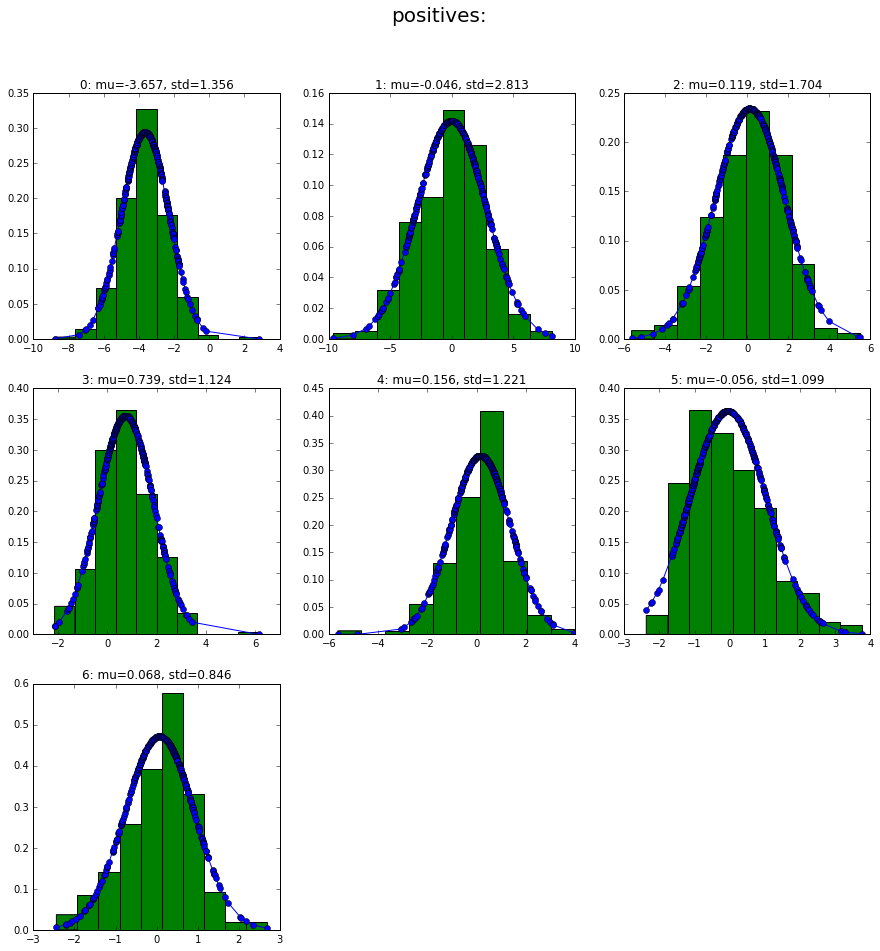

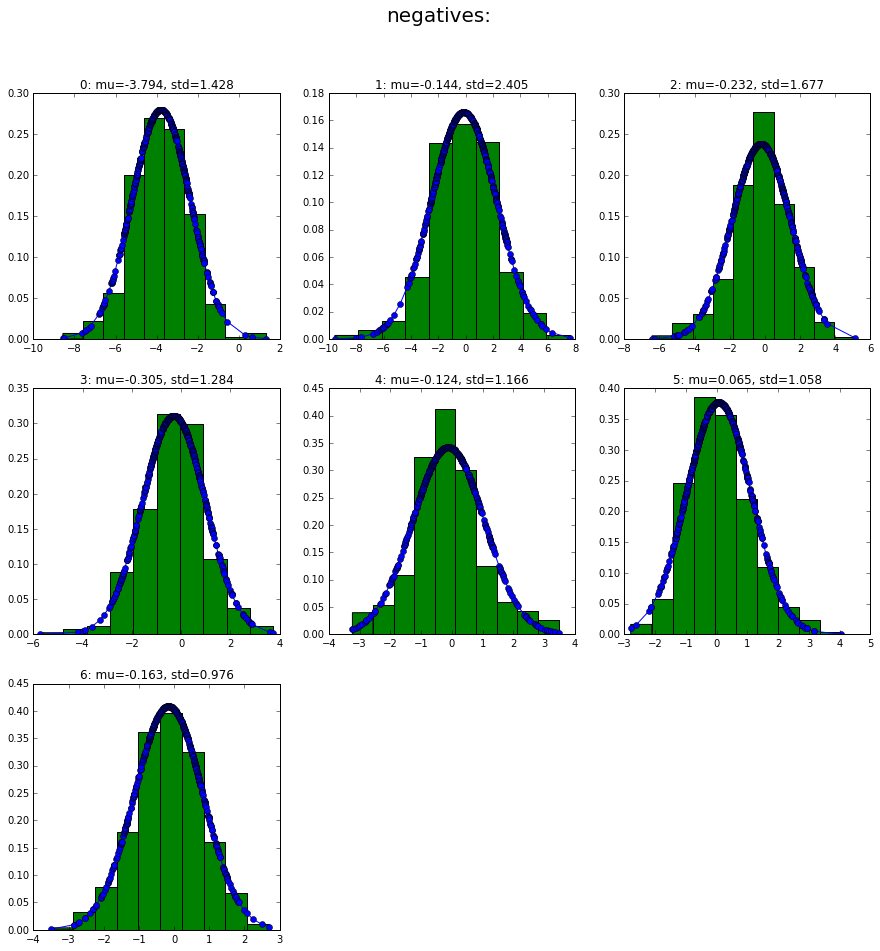

In [12]:
george_perceptron.learn(100)
george_gaussian.learn()

In [104]:
#GNB
c1_gnb = 0.2 # 0.00001 # 0.01
c2_gnb = 10.0 # 50 # 60

In [105]:
true_positive_gnb, false_positive = george_gaussian.classify(test_projected, test_labels, c1_gnb, False)
true_positive, false_positive_gnb = george_gaussian.classify(test_projected, test_labels, c2_gnb, False)
true_positive_gnb, false_positive_gnb

(0.0, 1.0)

In [106]:
#Perceptron
c1_p = -10
c2_p = 9

In [107]:
true_positive_p, false_positive = george_perceptron.classify(test_projected, test_labels, c1_p, False)
true_positive, false_positive_p = george_perceptron.classify(test_projected, test_labels, c2_p, False)
true_positive_p, false_positive_p

(0.0, 1.0)

In [109]:
steps = 200
c_vals_p = np.linspace(c1_p, c2_p, steps)
c_vals_gnb = np.linspace(c1_gnb, c2_gnb, steps)
tp_p,fp_p = zip(*[george_perceptron.classify(test_projected, test_labels, c, False) for c in c_vals_p])
tp_gnb,fp_gnb = zip(*[george_gaussian.classify(test_projected, test_labels, c, False) for c in c_vals_p])

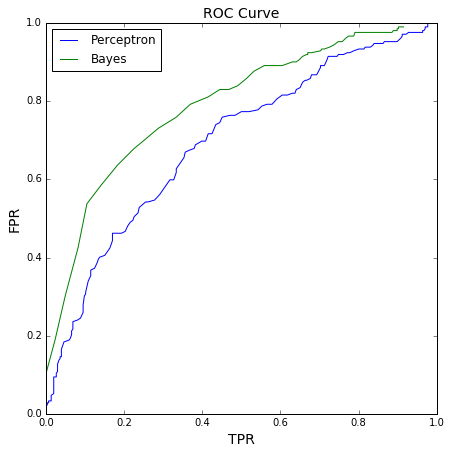

In [110]:
fig = plt.figure(figsize=(7,7))
ax = plt.subplot(1, 1, 1)
ax.plot(tp_p, fp_p)
ax.plot(tp_gnb,fp_gnb)
ax.legend(("Perceptron", "Bayes"), loc='best')
ax.set_title('ROC Curve', fontsize=14)
ax.set_xlabel("True positives", fontsize=14)
ax.set_ylabel("False positives", fontsize=14)
plt.show() 